<a href="https://colab.research.google.com/github/suacalis/IKA-YL/blob/main/%C5%9E%C3%87al%C4%B1%C5%9F_Linkedin_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!pip install pyjanitor pyvis --quiet

In [66]:
import pandas as pd
import janitor
import datetime
import numpy as np

from IPython.core.display import display, HTML
from pyvis import network as net
import networkx as nx

In [67]:
df = pd.read_csv("/content/Connections.csv", skiprows=2)

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472 entries, 0 to 471
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   First Name     469 non-null    object
 1   Last Name      469 non-null    object
 2   Email Address  7 non-null      object
 3   Company        456 non-null    object
 4   Position       456 non-null    object
 5   Connected On   472 non-null    object
dtypes: object(6)
memory usage: 22.2+ KB


## Data Cleaning

In [48]:
df = (
    df
    .clean_names() # remove spacing and capitalization
    .drop(columns=['first_name', 'last_name', 'email_address']) # drop for privacy
    .dropna(subset=['company', 'position']) # drop missing values in company and position
    .to_datetime('connected_on', format='%d %b %Y')
  )
df.head()

,company,position,connected_on
0,AIHR Academy,"Founder | Leader in HR Upskilling, HR Innovati...",2021-08-23
1,World University.london,Owner and Creator of World University,2021-08-16
2,Selvi Mobilya,İnsan Kaynakları Müdürü,2021-08-02
3,Medar Hastanesi Sakarya,İnsan Kaynakları Sorumlusu,2021-08-02
4,TIRSAN Treyler A.S.,İnsan Kaynakları ve Özlük İşleri,2021-07-12


## Simple EDA

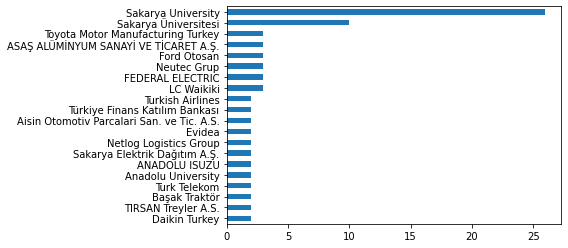

In [49]:
df['company'].value_counts().head(20).plot(kind="barh").invert_yaxis();

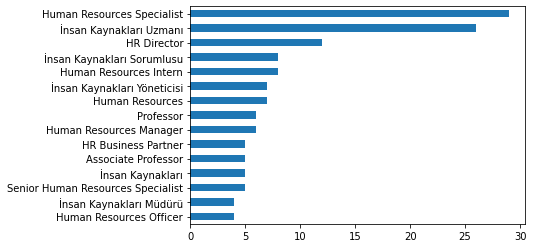

In [50]:
df['position'].value_counts().head(15).plot(kind="barh").invert_yaxis();

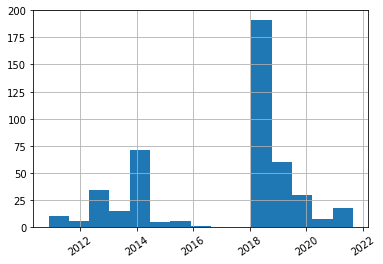

In [56]:
df['connected_on'].hist(xrot=35, bins=15);

### Remove freelance and self-employed titles

In [52]:
pattern = "freelance|self-employed"
df = df[~df['company'].str.contains(pattern, case=False)]

## Aggregate sum of connections for companies

In [57]:
df_company = df['company'].value_counts().reset_index()
df_company.columns = ['company', 'count']
df_company = df_company.sort_values(by="count", ascending=False)
df_company.head(15)

,company,count
0,Sakarya University,26
1,Sakarya Üniversitesi,10
2,FEDERAL ELECTRIC,3
3,ASAŞ ALÜMİNYUM SANAYİ VE TİCARET A.Ş.,3
4,Neutec Grup,3
5,LC Waikiki,3
6,Ford Otosan,3
7,Toyota Motor Manufacturing Turkey,3
24,Kocaeli Üniversitesi,2
21,Sigortam.net,2


## Aggregate sum of connections for positions

In [55]:
df_position = df['position'].value_counts().reset_index()
df_position.columns = ['position', 'count']
df_position = df_position.sort_values(by="count", ascending=False)
df_position.head(15)

,position,count
0,Human Resources Specialist,29
1,İnsan Kaynakları Uzmanı,26
2,HR Director,12
3,İnsan Kaynakları Sorumlusu,8
4,Human Resources Intern,8
5,Human Resources,7
6,İnsan Kaynakları Yöneticisi,7
7,Human Resources Manager,6
8,Professor,6
9,Associate Professor,5


## Creating the network

### Example of simple network

In [59]:
nt = net.Network(notebook=True)

g = nx.Graph()
g.add_node(0, label = "root") # intialize yourself as central node
g.add_node(1, label = "Company 1", size=10, title="info1")
g.add_node(2, label = "Company 2", size=40, title="info2")
g.add_node(3, label = "Company 3", size=60, title="info3")
g.add_edge(0, 1)
g.add_edge(0, 2)
g.add_edge(0, 3)

nt.from_nx(g)
nt.show('nodes.html')
display(HTML('nodes.html'))

In [60]:
print(f"number of nodes: {g.number_of_nodes()}")
print(f"number of edges: {g.number_of_edges()}")

number of nodes: 4
number of edges: 3


In [61]:
for _, row in df_company.head(5).iterrows():
  print(row['company'] + "-" + str(row['count']))

Sakarya University-26
Sakarya Üniversitesi-10
FEDERAL ELECTRIC-3
ASAŞ ALÜMİNYUM SANAYİ VE TİCARET A.Ş.-3
Neutec Grup-3


In [62]:
print(df_company.shape)
df_company_reduced = df_company.loc[df_company['count']>=5]
print(df_company_reduced.shape)

(386, 2)
(2, 2)


In [63]:
print(df_position.shape)
df_position_reduced = df_position.loc[df_position['count']>=5]
print(df_position_reduced.shape)

(299, 2)
(13, 2)


In [64]:
# initialize graph
g = nx.Graph()
g.add_node('root') # intialize yourself as central

# use iterrows tp iterate through the data frame
for _, row in df_company_reduced.iterrows():

  # store company name and count
  company = row['company']
  count = row['count']

  title = f"<b>{company}</b> – {count}"
  positions = set([x for x in df[company == df['company']]['position']])
  positions = ''.join('<li>{}</li>'.format(x) for x in positions)

  position_list = f"<ul>{positions}</ul>"
  hover_info = title + position_list

  g.add_node(company, size=count*2, title=hover_info, color='#3449eb')
  g.add_edge('root', company, color='grey')

# generate the graph
nt = net.Network(height='700px', width='700px', bgcolor="black", font_color='white')
nt.from_nx(g)
nt.hrepulsion()
# more customization https://tinyurl.com/yf5lvvdm
nt.show('company_graph.html')
display(HTML('company_graph.html'))

In [65]:
# initialize graph
g = nx.Graph()
g.add_node('root') # intialize yourself as central

# use iterrows tp iterate through the data frame
for _, row in df_position_reduced.iterrows():

  count = f"{row['count']}"
  position= row['position']
  
  g.add_node(position, size=count, color='#3449eb', title=count)
  g.add_edge('root', position, color='grey')

# generate the graph
nt = net.Network(height='700px', width='700px', bgcolor="black", font_color='white')
nt.from_nx(g)
nt.hrepulsion()
# more customization https://tinyurl.com/yf5lvvdm
nt.show('position_graph.html')
display(HTML('position_graph.html'))